# Report: Implementation of Kafka Broker in Python

*Author: Dimitrije Milenković*
<br> dimitrijemilenkovic.dm@gmail.com

In short, the task is described with the following goal:

*"The goal of the challenge is to have a tool that is able to stream data from Kafka and count unique things within this data. The simplest use case is that we want to calculate unique users per minute, day, week, month, year. For a very first version, business wants us to provide just the unique users per minute."*

It is recommended that I use my favorite programming language, solve the task, and write a report on why certain approach was choosen and what performance was gained.

My decision is to use Python. Although this is not the fastest alternative, I will give an overview of how this task can best be solved in this environment. 

## Kafka Clients Benchmark

At the very beginning, it is necessary to decide which Kafka client for Python is optimal for this problem. Our main metric is speed, so we'll choose a fastest client. For this need, three most popular clients were implemented and their performance measured. 


Before that we will implement a simple function of counting unique users per minute. Please note that in this section we focus on clients benchmarking and use the same counting mechanism. After selecting the best client, we will compare different counting mechanisms, data structures, and object serializer. At this point we assume that it is quite good to use numpy arrays.

In [1]:
import json
import time
import random
import string
import os
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import cProfile
import timeit

import ujson
import rapidjson
import ujson

from kafka import KafkaConsumer, KafkaProducer
from pykafka import KafkaClient
import confluent_kafka

GROUP_ID = 'kafka-clients-benchmark'
BOOTSTRAP_SERVERS = 'localhost:9092'

In [2]:
def count_unique_users_per_minute(messages: list):
    if len(messages) == 0:
        return {}, 0
    messages = np.array(messages)
    start = time.time()
    messages[:, 1] = messages[:, 1].astype('datetime64[m]')
    minutes = np.unique(messages[:, 1])
    num_of_unique_users = {}
    for minute in minutes:
        msgs_in_minute = messages[messages[:,1] == minute]
        num_of_unique_users[minute] = np.unique(msgs_in_minute[:, 0]).shape[0]
    timing = time.time() - start
    print(timing)
    return num_of_unique_users, timing 

### Kafka Python Client

In [4]:
def kafka_python_performance(input_topic_name, output_topic_name):
    group_id = ''.join(random.choices(string.ascii_uppercase + string.digits, k=10))
    start = time.time()
    messages = []

    consumer = KafkaConsumer(
        input_topic_name,
        bootstrap_servers=BOOTSTRAP_SERVERS,
        auto_offset_reset='earliest',
        enable_auto_commit=True,
        consumer_timeout_ms=1000,
        group_id=group_id,
        value_deserializer=lambda x: json.loads(x.decode('utf-8')))

    producer = KafkaProducer(
        bootstrap_servers=['localhost:9092'],
        value_serializer=lambda x: json.dumps(x).encode('utf-8'))

    for message in consumer:
        msg = [message.value['uid'], np.datetime64(message.value['ts'], 's')]
        # print('{} received.'.format(message))
        messages.append(msg)
    consumer.close()
    consumer_timing = time.time() - start

    num_of_unique_users = count_unique_users_per_minute(messages)[0]
    print(num_of_unique_users)
    producer.send(output_topic_name, value=num_of_unique_users)
    producer.close()
    producer_timing = time.time() - start
    
    print(len(messages), 'messages have been processed.')
    print('Execution time (seconds): ', consumer_timing)
    return len(messages), consumer_timing, producer_timing

In [5]:
num_of_messages, consumer_timings, producer_timings = {}, {}, {}
num_of_messages['kafka_python'], consumer_timings['kafka_python'], producer_timings[
    'kafka_python'] = kafka_python_performance('in', 'out')

1.5231025218963623
{'2016-07-11T13:39': 16193, '2016-07-11T13:40': 41130, '2016-07-11T13:41': 47369, '2016-07-11T13:42': 49488, '2016-07-11T13:43': 47863, '2016-07-11T13:44': 40439, '2016-07-11T13:45': 42859, '2016-07-11T13:46': 47312, '2016-07-11T13:47': 48180, '2016-07-11T13:48': 47981, '2016-07-11T13:49': 42194, '2016-07-11T13:50': 45070, '2016-07-11T13:51': 43659, '2016-07-11T13:52': 48611, '2016-07-11T13:53': 42742, '2016-07-11T13:54': 51930, '2016-07-11T13:55': 45471, '2016-07-11T13:56': 138}
1000000 messages have been processed.
Execution time (seconds):  61.850969552993774


### Pykafka Client

In [7]:
def pykafka_performance(input_topic_name, output_topic_name, use_rdkafka=False):
    group_id = ''.join(random.choices(string.ascii_uppercase + string.digits, k=10))
    start = time.time()
    client = KafkaClient(hosts=BOOTSTRAP_SERVERS)
    input_topic = client.topics[input_topic_name]
    
    consumer = input_topic.get_simple_consumer(use_rdkafka=use_rdkafka, consumer_group=group_id,
                                               consumer_timeout_ms=1000)
    messages = []
    while True:
        try:
            message = consumer.consume(block=True)
            message = json.loads(message.value.decode('utf-8')) 
        except AttributeError as e:
            print('No more messages', e)
            break
        
        msg = [message['uid'], np.datetime64(message['ts'], 's')]
        # print('{} received.'.format(message))
        messages.append(msg)
    consumer.stop()
    consumer_timing = time.time() - start
    
    start = time.time()
    num_of_unique_users = count_unique_users_per_minute(messages)[0]
    print(num_of_unique_users)
    output_topic = client.topics[output_topic_name]
    producer = output_topic.get_producer(use_rdkafka=use_rdkafka)
    producer.produce(json.dumps(num_of_unique_users).encode('utf-8'))
    producer.stop()
    producer_timing = time.time() - start

    print(len(messages), 'messages have been processed.')
    print('Execution time (seconds): ', consumer_timing)
    return len(messages), consumer_timing, producer_timing

In [8]:
num_of_messages['pykafka'], consumer_timings['pykafka'], producer_timings[
    'pykafka'] = pykafka_performance('in', 'outkp')

No more messages 'NoneType' object has no attribute 'value'
1.2501156330108643
{'2016-07-11T13:39': 16193, '2016-07-11T13:40': 41130, '2016-07-11T13:41': 47369, '2016-07-11T13:42': 49488, '2016-07-11T13:43': 47863, '2016-07-11T13:44': 40439, '2016-07-11T13:45': 42859, '2016-07-11T13:46': 47312, '2016-07-11T13:47': 48180, '2016-07-11T13:48': 47981, '2016-07-11T13:49': 42194, '2016-07-11T13:50': 45070, '2016-07-11T13:51': 43659, '2016-07-11T13:52': 48611, '2016-07-11T13:53': 42742, '2016-07-11T13:54': 51930, '2016-07-11T13:55': 45471, '2016-07-11T13:56': 138}
1000000 messages have been processed.
Execution time (seconds):  63.58131980895996


### Confluent Kafka Client

In [10]:
def confluent_kafka_performance(input_topic_name, output_topic_name):
    start = time.time()
    messages = []
    group_id = ''.join(random.choices(string.ascii_uppercase + string.digits, k=10))

    conf_consumer = {
        'bootstrap.servers': BOOTSTRAP_SERVERS,
        'group.id': group_id,
        'queue.buffering.max.messages': 500000,
        'queue.buffering.max.ms': 60000,
        'session.timeout.ms': 6000,
        'batch.num.messages': 100,
        'default.topic.config': {
            'auto.offset.reset': 'earliest',
            'acks': 'all'
        }
    }
    consumer = confluent_kafka.Consumer(**conf_consumer)
    consumer.subscribe([input_topic_name])

    while True:
        message = consumer.poll(timeout=4.0)
        if message is None:
            print('Message is None', len(messages))
            break
        if message.error():
            print("Consumer error: {}".format(message.error()))
            continue

        message = json.loads(message.value().decode('utf-8')) 
        msg = [message['uid'], np.datetime64(message['ts'], 's')]
        # print(msg, 'received.')
        messages.append(msg)
    
    consumer.close()
    consumer_timing = time.time() - start
    

    num_of_unique_users = count_unique_users_per_minute(messages)[0]
    print(num_of_unique_users)
    
    start = time.time()
    conf_producer = {'bootstrap.servers': BOOTSTRAP_SERVERS}
    producer = confluent_kafka.Producer(**conf_producer)
    producer.poll(0)
    producer.produce(output_topic_name, value=json.dumps(num_of_unique_users).encode('utf-8'))
#     producer.flush()
    producer_timing = time.time() - start
    print(len(messages), 'messages have been processed.')
    print('Execution time (seconds): ', consumer_timing)
    return len(messages), consumer_timing, producer_timing

In [11]:
num_of_messages['confluent_kafka'], consumer_timings['confluent_kafka'], producer_timings[
    'confluent_kafka'] = confluent_kafka_performance('in', 'outkp')

Consumer error: KafkaError{code=_PARTITION_EOF,val=-191,str="Broker: No more messages"}
Message is None 1000000
1.232053518295288
{'2016-07-11T13:39': 16193, '2016-07-11T13:40': 41130, '2016-07-11T13:41': 47369, '2016-07-11T13:42': 49488, '2016-07-11T13:43': 47863, '2016-07-11T13:44': 40439, '2016-07-11T13:45': 42859, '2016-07-11T13:46': 47312, '2016-07-11T13:47': 48180, '2016-07-11T13:48': 47981, '2016-07-11T13:49': 42194, '2016-07-11T13:50': 45070, '2016-07-11T13:51': 43659, '2016-07-11T13:52': 48611, '2016-07-11T13:53': 42742, '2016-07-11T13:54': 51930, '2016-07-11T13:55': 45471, '2016-07-11T13:56': 138}
1000000 messages have been processed.
Execution time (seconds):  36.256314277648926


### Client's Performance and Decision

We mentioned that the most important performance measure is speed, so we look at it as raw time, but also as the number of processed frames (messages) per second and the total amount of data processed per second. Also, besides the time consuming messages, time needed for pushing the message is also important although we do it less often.

In [12]:
path = '/home/dimi/Projects/kafka-benchmark/'
file_path = path + 'data/stream.jsonl'
stats_file_path = path + 'data/clients_comparison_stats.csv'
fig_path = path + 'figs/comparison_graph.pdf'

msg_size = os.path.getsize(file_path)

df = pd.DataFrame.from_dict(consumer_timings, orient='index').rename(columns={0: 'time_in_seconds'})
df['consumed_Bs/s'] = msg_size / df.time_in_seconds 
df['consumed_Frames/s'] = list(num_of_messages.values()) / df.time_in_seconds
df['producer_time'] = list(producer_timings.values())
df.sort_values(by='time_in_seconds', inplace=True)
df

,time_in_seconds,consumed_Bs/s,consumed_Frames/s,producer_time
confluent_kafka,36.256314,5.737910e+07,27581.402576,0.000240
kafka_python,61.850970,3.363495e+07,16167.895301,64.242454
pykafka,63.581320,3.271959e+07,15727.889937,12.014478


Results was saved in:
- data:  /home/dimi/Projects/kafka-benchmark/data/clients_comparison_stats.csv
- graph:  /home/dimi/Projects/kafka-benchmark/figs/comparison_graph.pdf


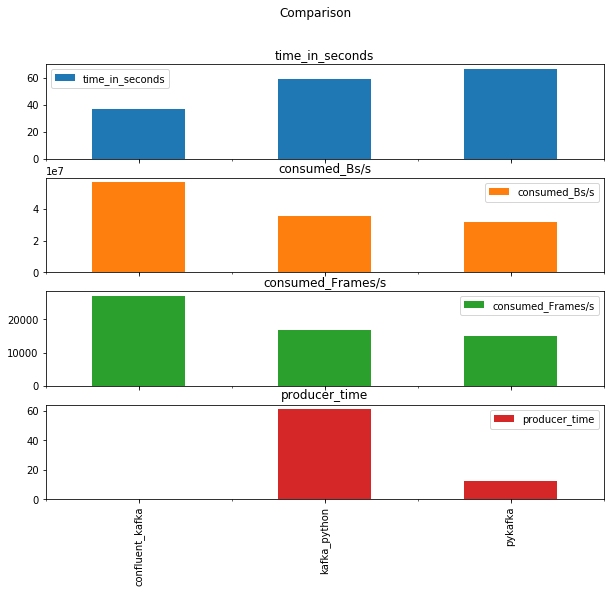

In [25]:
df.plot(kind='bar', subplots=True, figsize=(10, 8), title="Comparison")

df.to_csv(stats_file_path)
plt.savefig(fig_path)
print('Results was saved in:')
print('- data: ', stats_file_path)
print('- graph: ', fig_path)

As we can see, the best client is the Confluent Kafka Client, so we will choose it. 

The next step will be to determine the bottlenecks of our functions and optimize these parts. Within this, the optimal data structure for the messages will be selected.

### Performance  Measurement and Bottlenecks Identification

In this section we will concentrate only on `confluent_kafka_performance` function, we measure its performance, try to determine which parts of it are the slowest and speed them up.

In [27]:
cProfile.run('confluent_kafka_performance(\'in\', \'outkp\')')

Consumer error: KafkaError{code=_PARTITION_EOF,val=-191,str="Broker: No more messages"}
Message is None 1000000
1.3167636394500732
{'2016-07-11T13:39': 16193, '2016-07-11T13:40': 41130, '2016-07-11T13:41': 47369, '2016-07-11T13:42': 49488, '2016-07-11T13:43': 47863, '2016-07-11T13:44': 40439, '2016-07-11T13:45': 42859, '2016-07-11T13:46': 47312, '2016-07-11T13:47': 48180, '2016-07-11T13:48': 47981, '2016-07-11T13:49': 42194, '2016-07-11T13:50': 45070, '2016-07-11T13:51': 43659, '2016-07-11T13:52': 48611, '2016-07-11T13:53': 42742, '2016-07-11T13:54': 51930, '2016-07-11T13:55': 45471, '2016-07-11T13:56': 138}
1000000 messages have been processed.
Execution time (seconds):  40.7210168838501
         15000520 function calls in 43.147 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.593    0.593    2.219    2.219 <ipython-input-2-67194e63a97a>:1(count_unique_users_per_minute)
        1    3.320    3.320   42.946  

From this report it is clear that JSON deserialization is the slowest operation, as we assumed. That is why we will deal with different alternatives for the deserialization of JSON objects in the forthcoming section.

## Choosing the Optimal JSON Serializer

We will try these alternatives for JSON encoders:
- json
- ujson
- rapidjson

In [13]:
setup = "from __main__ import confluent_kafka_performance"
json_timings = {}
json_timings['json'] = timeit.timeit('confluent_kafka_performance(\'in\', \'outkp\')', setup=setup, number=3) / 3

Consumer error: KafkaError{code=_PARTITION_EOF,val=-191,str="Broker: No more messages"}
Message is None 1000000
1.2124454975128174
{'2016-07-11T13:39': 16193, '2016-07-11T13:40': 41130, '2016-07-11T13:41': 47369, '2016-07-11T13:42': 49488, '2016-07-11T13:43': 47863, '2016-07-11T13:44': 40439, '2016-07-11T13:45': 42859, '2016-07-11T13:46': 47312, '2016-07-11T13:47': 48180, '2016-07-11T13:48': 47981, '2016-07-11T13:49': 42194, '2016-07-11T13:50': 45070, '2016-07-11T13:51': 43659, '2016-07-11T13:52': 48611, '2016-07-11T13:53': 42742, '2016-07-11T13:54': 51930, '2016-07-11T13:55': 45471, '2016-07-11T13:56': 138}
1000000 messages have been processed.
Execution time (seconds):  34.89056921005249
Consumer error: KafkaError{code=_PARTITION_EOF,val=-191,str="Broker: No more messages"}
Message is None 1000000
1.2861905097961426
{'2016-07-11T13:39': 16193, '2016-07-11T13:40': 41130, '2016-07-11T13:41': 47369, '2016-07-11T13:42': 49488, '2016-07-11T13:43': 47863, '2016-07-11T13:44': 40439, '2016-0

In [14]:
def confluent_kafka_performance(input_topic_name, output_topic_name):
    start = time.time()
    messages = []
    group_id = ''.join(random.choices(string.ascii_uppercase + string.digits, k=10))

    conf_consumer = {
        'bootstrap.servers': BOOTSTRAP_SERVERS,
        'group.id': group_id,
        'queue.buffering.max.messages': 500000,
        'queue.buffering.max.ms': 60000,
        'session.timeout.ms': 6000,
        'batch.num.messages': 100,
        'default.topic.config': {
            'auto.offset.reset': 'earliest',
            'acks': 'all'
        }
    }
    consumer = confluent_kafka.Consumer(**conf_consumer)
    consumer.subscribe([input_topic_name])

    while True:
        message = consumer.poll(timeout=4.0)
        if message is None:
            print('Message is None', len(messages))
            break
        if message.error():
            print("Consumer error: {}".format(message.error()))
            continue

        message = ujson.loads(message.value().decode('utf-8')) 
        msg = [message['uid'], np.datetime64(message['ts'], 's')]
        # print(msg, 'received.')
        messages.append(msg)
    
    consumer.close()
    consumer_timing = time.time() - start
    

    num_of_unique_users = count_unique_users_per_minute(messages)[0]
    print(num_of_unique_users)
    
    start = time.time()
    conf_producer = {'bootstrap.servers': BOOTSTRAP_SERVERS}
    producer = confluent_kafka.Producer(**conf_producer)
    producer.poll(0)
    producer.produce(output_topic_name, value=ujson.dumps(num_of_unique_users).encode('utf-8'))
    producer.flush()
    producer_timing = time.time() - start
    print(len(messages), 'messages have been processed.')
    print('Execution time (seconds): ', consumer_timing)
    return len(messages), consumer_timing, producer_timing

json_timings['ujson'] = timeit.timeit('confluent_kafka_performance(\'in\', \'outkp\')', setup=setup, number=3) / 3

Consumer error: KafkaError{code=_PARTITION_EOF,val=-191,str="Broker: No more messages"}
Message is None 1000000
1.1873900890350342
{'2016-07-11T13:39': 16193, '2016-07-11T13:40': 41130, '2016-07-11T13:41': 47369, '2016-07-11T13:42': 49488, '2016-07-11T13:43': 47863, '2016-07-11T13:44': 40439, '2016-07-11T13:45': 42859, '2016-07-11T13:46': 47312, '2016-07-11T13:47': 48180, '2016-07-11T13:48': 47981, '2016-07-11T13:49': 42194, '2016-07-11T13:50': 45070, '2016-07-11T13:51': 43659, '2016-07-11T13:52': 48611, '2016-07-11T13:53': 42742, '2016-07-11T13:54': 51930, '2016-07-11T13:55': 45471, '2016-07-11T13:56': 138}
1000000 messages have been processed.
Execution time (seconds):  21.700391054153442
Consumer error: KafkaError{code=_PARTITION_EOF,val=-191,str="Broker: No more messages"}
Message is None 1000000
1.2064800262451172
{'2016-07-11T13:39': 16193, '2016-07-11T13:40': 41130, '2016-07-11T13:41': 47369, '2016-07-11T13:42': 49488, '2016-07-11T13:43': 47863, '2016-07-11T13:44': 40439, '2016-

In [15]:
def confluent_kafka_performance(input_topic_name, output_topic_name):
    start = time.time()
    messages = []
    group_id = ''.join(random.choices(string.ascii_uppercase + string.digits, k=10))

    conf_consumer = {
        'bootstrap.servers': BOOTSTRAP_SERVERS,
        'group.id': group_id,
        'queue.buffering.max.messages': 500000,
        'queue.buffering.max.ms': 60000,
        'session.timeout.ms': 6000,
        'batch.num.messages': 100,
        'default.topic.config': {
            'auto.offset.reset': 'earliest',
            'acks': 'all'
        }
    }
    consumer = confluent_kafka.Consumer(**conf_consumer)
    consumer.subscribe([input_topic_name])

    while True:
        message = consumer.poll(timeout=4.0)
        if message is None:
            print('Message is None', len(messages))
            break
        if message.error():
            print("Consumer error: {}".format(message.error()))
            continue

        message = rapidjson.loads(message.value().decode('utf-8')) 
        msg = [message['uid'], np.datetime64(message['ts'], 's')]
        # print(msg, 'received.')
        messages.append(msg)
    
    consumer.close()
    consumer_timing = time.time() - start
    

    num_of_unique_users = count_unique_users_per_minute(messages)[0]
    print(num_of_unique_users)
    
    start = time.time()
    conf_producer = {'bootstrap.servers': BOOTSTRAP_SERVERS}
    producer = confluent_kafka.Producer(**conf_producer)
    producer.poll(0)
    producer.produce(output_topic_name, value=rapidjson.dumps(num_of_unique_users).encode('utf-8'))
    producer.flush()
    producer_timing = time.time() - start
    print(len(messages), 'messages have been processed.')
    print('Execution time (seconds): ', consumer_timing)
    return len(messages), consumer_timing, producer_timing


json_timings['rapidjson']  = timeit.timeit('confluent_kafka_performance(\'in\', \'outkp\')',
                                           setup=setup, number=3) / 3

Consumer error: KafkaError{code=_PARTITION_EOF,val=-191,str="Broker: No more messages"}
Message is None 1000000
1.219083309173584
{'2016-07-11T13:39': 16193, '2016-07-11T13:40': 41130, '2016-07-11T13:41': 47369, '2016-07-11T13:42': 49488, '2016-07-11T13:43': 47863, '2016-07-11T13:44': 40439, '2016-07-11T13:45': 42859, '2016-07-11T13:46': 47312, '2016-07-11T13:47': 48180, '2016-07-11T13:48': 47981, '2016-07-11T13:49': 42194, '2016-07-11T13:50': 45070, '2016-07-11T13:51': 43659, '2016-07-11T13:52': 48611, '2016-07-11T13:53': 42742, '2016-07-11T13:54': 51930, '2016-07-11T13:55': 45471, '2016-07-11T13:56': 138}
1000000 messages have been processed.
Execution time (seconds):  23.233295917510986
Consumer error: KafkaError{code=_PARTITION_EOF,val=-191,str="Broker: No more messages"}
Message is None 1000000
1.206662654876709
{'2016-07-11T13:39': 16193, '2016-07-11T13:40': 41130, '2016-07-11T13:41': 47369, '2016-07-11T13:42': 49488, '2016-07-11T13:43': 47863, '2016-07-11T13:44': 40439, '2016-07

,time_in_seconds
ujson,24.615031
rapidjson,26.667731
json,37.448346


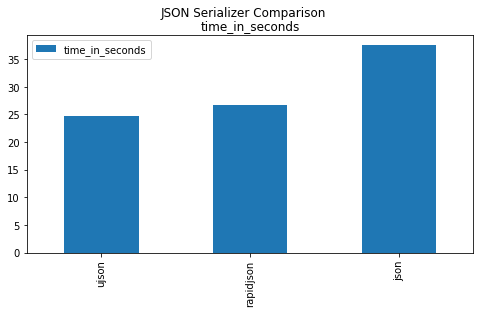

In [18]:
df_json = pd.DataFrame.from_dict(json_timings, orient='index').rename(columns={0: 'time_in_seconds'})
df_json.sort_values(by='time_in_seconds', inplace=True)
df_json.plot(kind='bar', subplots=True, figsize=(8,4), title="JSON Serializer Comparison")
df_json

We noticed that the best results were given by the ujson, so we would use it further.

### Selecting the Optimal Data Structure

Next step can be to optimize data structure in which objects will be appended. As common data structures for saving a list of objects such as messages, we have:
- lists
- numpy arrays

In the beginning, we choose list as a data structure that is more convenient for appending. The reason for this is that np.append() copy all the data in the array every time, but the list grows the capacity by a factor (1.125). The list is fast, but memory usage is larger than the array. Because memory usage is not a primary concern for our case, the list seems to be an optimal structure.

On the other hand, lists don't be a good structure for subsetting or perform counting, and it's more appropriate to cast list in numpy array.

We don't have to believe in this, we can test our base function and function with numpy arrays. The assumption is that the numpy array will work very slowly, so we will test this for just 20000 messages.

In [21]:
def count_unique_users_per_minute(messages):
    messages = np.array(messages)
    start = time.time()
    messages[:, 1] = messages[:, 1].astype('datetime64[m]')
    minutes = np.unique(messages[:, 1])
    num_of_unique_users = {}
    for minute in minutes:
        msgs_in_minute = messages[messages[:,1] == minute]
        num_of_unique_users[minute] = np.unique(msgs_in_minute[:, 0]).shape[0]
    timing = time.time() - start
    print(timing)
    return num_of_unique_users, timing 

def confluent_kafka_performance(input_topic_name, output_topic_name):
    start = time.time()
    messages = []
    group_id = ''.join(random.choices(string.ascii_uppercase + string.digits, k=10))

    conf_consumer = {
        'bootstrap.servers': BOOTSTRAP_SERVERS,
        'group.id': group_id,
        'queue.buffering.max.messages': 500000,
        'queue.buffering.max.ms': 60000,
        'session.timeout.ms': 6000,
        'batch.num.messages': 100,
        'default.topic.config': {
            'auto.offset.reset': 'earliest',
            'acks': 'all'
        }
    }
    consumer = confluent_kafka.Consumer(**conf_consumer)
    consumer.subscribe([input_topic_name])
    c=0
    while True and c < 20000:
        message = consumer.poll(timeout=4.0)
        if message is None:
            print('Message is None', len(messages))
            break
        if message.error():
            print("Consumer error: {}".format(message.error()))
            continue

        message = ujson.loads(message.value().decode('utf-8')) 
        msg = [message['uid'], np.datetime64(message['ts'], 's')]
        # print(msg, 'received.')
        messages.append(msg)
        c=c+1
    
    consumer.close()
    consumer_timing = time.time() - start
    

    num_of_unique_users = count_unique_users_per_minute(messages)[0]
    print(num_of_unique_users)
    
    start = time.time()
    conf_producer = {'bootstrap.servers': BOOTSTRAP_SERVERS}
    producer = confluent_kafka.Producer(**conf_producer)
    producer.poll(0)
    producer.produce(output_topic_name, value=ujson.dumps(num_of_unique_users).encode('utf-8'))
    producer.flush()
    producer_timing = time.time() - start
    print(len(messages), 'messages have been processed.')
    print('Execution time (seconds): ', consumer_timing)
    return len(messages), consumer_timing, producer_timing


data_structure_comparison = {}
setup = "from __main__ import confluent_kafka_performance"
data_structure_comparison['list'] = timeit.timeit('confluent_kafka_performance(\'in\', \'outkp\')', 
                                                   setup=setup, number=1) 

0.02117776870727539
{'2016-07-11T13:39': 16193, '2016-07-11T13:40': 2233}
20000 messages have been processed.
Execution time (seconds):  0.509284496307373


In [22]:
def count_unique_users_per_minute(messages):
    start = time.time()
    messages[:, 1] = messages[:, 1].astype('datetime64[m]')
    minutes = np.unique(messages[:, 1])
    num_of_unique_users = {}
    for minute in minutes:
        msgs_in_minute = messages[messages[:,1] == minute]
        num_of_unique_users[minute] = np.unique(msgs_in_minute[:, 0]).shape[0]
    timing = time.time() - start
    print(timing)
    return num_of_unique_users, timing 

def confluent_kafka_performance(input_topic_name, output_topic_name):
    start = time.time()
    messages = np.array([])
    group_id = ''.join(random.choices(string.ascii_uppercase + string.digits, k=10))

    conf_consumer = {
        'bootstrap.servers': BOOTSTRAP_SERVERS,
        'group.id': group_id,
        'queue.buffering.max.messages': 500000,
        'queue.buffering.max.ms': 60000,
        'session.timeout.ms': 6000,
        'batch.num.messages': 100,
        'default.topic.config': {
            'auto.offset.reset': 'earliest',
            'acks': 'all'
        }
    }
    consumer = confluent_kafka.Consumer(**conf_consumer)
    consumer.subscribe([input_topic_name])

    c=0
    while True and c < 20000:
        message = consumer.poll(timeout=4.0)
        if message is None:
            print('Message is None', len(messages))
            break
        if message.error():
            print("Consumer error: {}".format(message.error()))
            continue

        message = ujson.loads(message.value().decode('utf-8')) 
        msg = [message['uid'], np.datetime64(message['ts'], 's')]
        
        messages = np.append(messages, msg)
        c = c+1
    messages = np.reshape(messages, (-1, 2))
    consumer.close()
    consumer_timing = time.time() - start
    

    num_of_unique_users = count_unique_users_per_minute(messages)[0]
    print(num_of_unique_users)
    
    start = time.time()
    conf_producer = {'bootstrap.servers': BOOTSTRAP_SERVERS}
    producer = confluent_kafka.Producer(**conf_producer)
    producer.poll(0)
    producer.produce(output_topic_name, value=ujson.dumps(num_of_unique_users).encode('utf-8'))
    producer.flush()
    producer_timing = time.time() - start
    print(len(messages), 'messages have been processed.')
    print('Execution time (seconds): ', consumer_timing)
    return len(messages), consumer_timing, producer_timing

data_structure_comparison['array'] = timeit.timeit('confluent_kafka_performance(\'in\', \'outkp\')', 
                                                   setup=setup, number=1) 

0.048035621643066406
{'2016-07-11T13:39': 16193, '2016-07-11T13:40': 2233}
20000 messages have been processed.
Execution time (seconds):  7.637610912322998


We have proven our assumption. However, there is another solution. We use appending when we don't know how many messages will be sent at the moment. Though we have historical data and we can assume how many messages will arrive at a certain time interval. For example, if we know that it is 1 million messages per second, we can allocate an array length of 1 million, so we put messages in them every time when a new message arrives. if our assumption is not correct and there are more messages, then we can allocate a longer array. There is only 1 new allocation, not on every message. On the other hand, the problem with this can be that we need to clear out a range of free space when we finish reading messages. That means that we need a logical expression and another allocation. Let's try this and measure performance:

In [24]:
def confluent_kafka_performance(input_topic_name, output_topic_name, presumed_num_of_messages=10**6):
    start = time.time()
    messages = np.zeros((presumed_num_of_messages, 2)).astype('object')
    array_length = presumed_num_of_messages
    group_id = ''.join(random.choices(string.ascii_uppercase + string.digits, k=10))

    conf_consumer = {
        'bootstrap.servers': BOOTSTRAP_SERVERS,
        'group.id': group_id,
        'queue.buffering.max.messages': 500000,
        'queue.buffering.max.ms': 60000,
        'session.timeout.ms': 6000,
        'batch.num.messages': 100,
        'default.topic.config': {
            'auto.offset.reset': 'earliest',
            'acks': 'all'
        }
    }
    consumer = confluent_kafka.Consumer(**conf_consumer)
    consumer.subscribe([input_topic_name])

    counter = 0
    while True and counter < 20000:
        if counter+1 == messages.shape[0]:
            messages = np.vstack([messages, np.zeros((presumed_num_of_messages, 2)).astype('object')])
            array_length = messages.shape[0]
        message = consumer.poll(timeout=4.0)
        if message is None:
            print('Message is None', len(messages))
            break
        if message.error():
            print("Consumer error: {}".format(message.error()))
            continue

        message = ujson.loads(message.value().decode('utf-8')) 
        messages[counter, :] = [message['uid'], np.datetime64(message['ts'], 's')]
        counter = counter + 1
    
    consumer.close()
    consumer_timing = time.time() - start
    
    messages = messages[np.logical_and(messages[:, 0] != 0, messages[:, 1] != 0)]
    num_of_unique_users = count_unique_users_per_minute(messages)[0]
    print(num_of_unique_users)
    
    start = time.time()
    conf_producer = {'bootstrap.servers': BOOTSTRAP_SERVERS}
    producer = confluent_kafka.Producer(**conf_producer)
    producer.poll(0)
    producer.produce(output_topic_name, value=ujson.dumps(num_of_unique_users).encode('utf-8'))
    producer.flush()
    producer_timing = time.time() - start
    print(len(messages), 'messages have been processed.')
    print('Execution time (seconds): ', consumer_timing)
    return len(messages), consumer_timing, producer_timing

data_structure_comparison['preallocated_array'] = timeit.timeit('confluent_kafka_performance(\'in\', \'outkp\')', 
                                                   setup=setup, number=1) 

/home/dimi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


0.019622802734375
{datetime.datetime(2016, 7, 11, 13, 39): 16193, datetime.datetime(2016, 7, 11, 13, 40): 2233}
20000 messages have been processed.
Execution time (seconds):  0.5473260879516602


It seems that numpy allocations still cost more than working with lists. We'll show statistics and finally choose lists.

,time_in_seconds
list,1.686618
preallocated_array,1.784019
array,8.789447


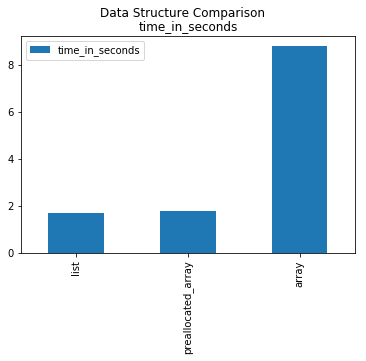

In [25]:
df_datastructures = pd.DataFrame.from_dict(data_structure_comparison, orient='index').rename(columns={0: 'time_in_seconds'})
df_datastructures.sort_values(by='time_in_seconds', inplace=True)
df_datastructures.plot(kind='bar', subplots=True, figsize=(6, 4), title="Data Structure Comparison")
df_datastructures

Now that we have chosen the best structure, we will enrich our counting function for counting unique users per minute, day, week, month, year.

## Counting unique users per different time ranges

In [2]:
def count_by_date(messages):
    dates = np.unique(messages[:, 1])
    num_of_unique_users = {}
    for dt in dates:
        msgs_in_dt = messages[messages[:,1] == dt]
        num_of_unique_users[dt] = np.unique(msgs_in_dt[:, 0]).shape[0]
    return num_of_unique_users

        
def count_unique_users(messages):
    if len(messages) == 0:
        return {}, 0
    messages = np.array(messages)
    unique_users = {}
    
    messages[:, 1] = messages[:, 1].astype('datetime64[m]')
    unique_users['per_minute'] = count_by_date(messages)
        
    messages[:, 1] = messages[:, 1].astype('datetime64[h]')
    unique_users['per_hour'] = count_by_date(messages)

    messages[:, 1] = messages[:, 1].astype('datetime64[D]')
    unique_users['per_day'] = count_by_date(messages)
    
    messages[:, 1] = messages[:, 1].astype('datetime64[M]')
    unique_users['per_month'] = count_by_date(messages)
    
    messages[:, 1] = messages[:, 1].astype('datetime64[Y]')
    unique_users['per_year'] = count_by_date(messages)

    return unique_users 

At the end, we run our code one more time and measure final performances.

In [7]:
def read_messages_and_count_users(input_topic_name, output_topic_name, presumed_num_of_messages=10**6):
    messages = []
    group_id = ''.join(random.choices(string.ascii_uppercase + string.digits, k=10))

    conf_consumer = {
        'bootstrap.servers': BOOTSTRAP_SERVERS,
        'group.id': group_id,
        'queue.buffering.max.messages': 500000,
        'queue.buffering.max.ms': 60000,
        'session.timeout.ms': 6000,
        'batch.num.messages': 100,
        'default.topic.config': {
            'auto.offset.reset': 'earliest',
            'acks': 'all'
        }
    }
    consumer = confluent_kafka.Consumer(**conf_consumer)
    consumer.subscribe([input_topic_name])

    while True:
        message = consumer.poll(timeout=4.0)
        if message is None:
            print('Message is None', len(messages))
            break
        if message.error():
            print("Consumer error: {}".format(message.error()))
            continue

        message = ujson.loads(message.value().decode('utf-8')) 
        messages.append([message['uid'], np.datetime64(message['ts'], 's')])
    
    consumer.close()
    
    num_of_unique_users = count_unique_users(messages)
    
    conf_producer = {'bootstrap.servers': BOOTSTRAP_SERVERS}
    producer = confluent_kafka.Producer(**conf_producer)
    producer.poll(0)
    producer.produce(output_topic_name, value=ujson.dumps(num_of_unique_users).encode('utf-8'))
    print(num_of_unique_users)
    return num_of_unique_users

cProfile.run('read_messages_and_count_users(\'in\', \'outkp\')')

Consumer error: KafkaError{code=_PARTITION_EOF,val=-191,str="Broker: No more messages"}
Message is None 1000000
{'per_minute': {'2016-07-11T13:39': 16193, '2016-07-11T13:40': 41130, '2016-07-11T13:41': 47369, '2016-07-11T13:42': 49488, '2016-07-11T13:43': 47863, '2016-07-11T13:44': 40439, '2016-07-11T13:45': 42859, '2016-07-11T13:46': 47312, '2016-07-11T13:47': 48180, '2016-07-11T13:48': 47981, '2016-07-11T13:49': 42194, '2016-07-11T13:50': 45070, '2016-07-11T13:51': 43659, '2016-07-11T13:52': 48611, '2016-07-11T13:53': 42742, '2016-07-11T13:54': 51930, '2016-07-11T13:55': 45471, '2016-07-11T13:56': 138}, 'per_hour': {'2016-07-11T13': 99993}, 'per_day': {'2016-07-11': 99993}, 'per_month': {'2016-07': 99993}, 'per_year': {'2016': 99993}}
         6000458 function calls in 30.081 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        5    0.567    0.113    3.053    0.611 <ipython-input-2-c3178f845a38>:1(count_by_date)
      

We can notice that one of the slowest operations is time extraction from date, and the logical conditions that were written in the count_by_date function. However, these are all statistics that can be calculated from the statistics per minute, so we can get them out of here.

## Final Solution

In [11]:
def count_unique_users_per_minute(messages):
    messages = np.array(messages)
    messages[:, 1] = messages[:, 1].astype('datetime64[m]')
    minutes = np.unique(messages[:, 1])
    num_of_unique_users = {}
    for minute in minutes:
        msgs_in_minute = messages[messages[:,1] == minute]
        num_of_unique_users[minute] = np.unique(msgs_in_minute[:, 0]).shape[0]
    return num_of_unique_users

def read_messages_and_count_users(input_topic_name, output_topic_name, presumed_num_of_messages=10**6):
    messages = []
    group_id = ''.join(random.choices(string.ascii_uppercase + string.digits, k=10))

    conf_consumer = {
        'bootstrap.servers': BOOTSTRAP_SERVERS,
        'group.id': group_id,
        'queue.buffering.max.messages': 500000,
        'queue.buffering.max.ms': 60000,
        'session.timeout.ms': 6000,
        'batch.num.messages': 100,
        'default.topic.config': {
            'auto.offset.reset': 'earliest',
            'acks': 'all'
        }
    }
    consumer = confluent_kafka.Consumer(**conf_consumer)
    consumer.subscribe([input_topic_name])

    while True:
        message = consumer.poll(timeout=4.0)
        if message is None:
            print('Message is None', len(messages))
            break
        if message.error():
            print("Consumer error: {}".format(message.error()))
            continue

        message = ujson.loads(message.value().decode('utf-8')) 
        messages.append([message['uid'], np.datetime64(message['ts'], 's')])
    
    consumer.close()
    
    num_of_unique_users = count_unique_users_per_minute(messages)
    
    conf_producer = {'bootstrap.servers': BOOTSTRAP_SERVERS}
    producer = confluent_kafka.Producer(**conf_producer)
    producer.poll(0)
    producer.produce(output_topic_name, value=ujson.dumps(num_of_unique_users).encode('utf-8'))
    print(num_of_unique_users)
    return num_of_unique_users

cProfile.run('read_messages_and_count_users(\'in\', \'outkp\')')

Consumer error: KafkaError{code=_PARTITION_EOF,val=-191,str="Broker: No more messages"}
Message is None 1000000
{'2016-07-11T13:39': 16193, '2016-07-11T13:40': 41130, '2016-07-11T13:41': 47369, '2016-07-11T13:42': 49488, '2016-07-11T13:43': 47863, '2016-07-11T13:44': 40439, '2016-07-11T13:45': 42859, '2016-07-11T13:46': 47312, '2016-07-11T13:47': 48180, '2016-07-11T13:48': 47981, '2016-07-11T13:49': 42194, '2016-07-11T13:50': 45070, '2016-07-11T13:51': 43659, '2016-07-11T13:52': 48611, '2016-07-11T13:53': 42742, '2016-07-11T13:54': 51930, '2016-07-11T13:55': 45471, '2016-07-11T13:56': 138}
         6000373 function calls in 26.212 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.552    0.552    1.944    1.944 <ipython-input-11-4b7839d9904d>:1(count_unique_users_per_minute)
        1    2.493    2.493   26.046   26.046 <ipython-input-11-4b7839d9904d>:11(read_messages_and_count_users)
        1    0.165    0.165

## Conclusion

Problems and bottlenecks in these tasks are independent of the programming language. In this report, I tried to identify bottlenecks, show how we can measure performance and optimize them.

This is definitely a prototype solution because Python is not the optimal language for these problems. However, in comparison to initial performance, we managed to improve them 3 times, which indicates that we have been well aware of which parts should be optimized.

In [12]:
setup = "from __main__ import read_messages_and_count_users"
final_time = timeit.timeit('read_messages_and_count_users(\'in\', \'outkp\')', 
                                                   setup=setup, number=10) 

Consumer error: KafkaError{code=_PARTITION_EOF,val=-191,str="Broker: No more messages"}
Message is None 1000000
{'2016-07-11T13:39': 16193, '2016-07-11T13:40': 41130, '2016-07-11T13:41': 47369, '2016-07-11T13:42': 49488, '2016-07-11T13:43': 47863, '2016-07-11T13:44': 40439, '2016-07-11T13:45': 42859, '2016-07-11T13:46': 47312, '2016-07-11T13:47': 48180, '2016-07-11T13:48': 47981, '2016-07-11T13:49': 42194, '2016-07-11T13:50': 45070, '2016-07-11T13:51': 43659, '2016-07-11T13:52': 48611, '2016-07-11T13:53': 42742, '2016-07-11T13:54': 51930, '2016-07-11T13:55': 45471, '2016-07-11T13:56': 138}
Consumer error: KafkaError{code=_PARTITION_EOF,val=-191,str="Broker: No more messages"}
Message is None 1000000
{'2016-07-11T13:39': 16193, '2016-07-11T13:40': 41130, '2016-07-11T13:41': 47369, '2016-07-11T13:42': 49488, '2016-07-11T13:43': 47863, '2016-07-11T13:44': 40439, '2016-07-11T13:45': 42859, '2016-07-11T13:46': 47312, '2016-07-11T13:47': 48180, '2016-07-11T13:48': 47981, '2016-07-11T13:49': 

In [15]:
print('The average execution time is', final_time/10, 'seconds')

The average execution time is 24.43195378119999 seconds
